## 얼굴 남기기 crop 변환

In [1]:
import numpy as np
import cv2
import os
from glob import glob
from matplotlib import pyplot as plt
from tqdm import tqdm
face_cascade = cv2.CascadeClassifier('./haarcascade_frontface.xml')


# 소스 데이터 path및 경로명
src_path = '.\\2020-02-092.한국인감정인식_sample\\원천데이터'


folder_list = os.listdir(src_path)
folder = folder_list[0]
folder


'기쁨'

In [2]:
# 저장할 폴더 제작
dest_path = './emotion_cv2'
try:
    os.mkdir(dest_path)
except:
    pass

In [3]:
# 저장할 폴더 제작
for f in folder_list:
    try:
        os.mkdir(os.path.join(dest_path , f))
    except:
        pass

In [ ]:
for cnt, f in enumerate(folder_list):
    src_f = os.path.join(src_path, f)
    dest_f = os.path.join(dest_path, f)
    image_list = os.listdir(src_f)
    for i in tqdm(image_list):
        src_image = os.path.join(src_f, i)
        dest_image = os.path.join(dest_f, i)
        img_array = np.fromfile(src_image, np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, minNeighbors=4, minSize = [256,256])
        if len(faces) == 1:
            for (x,y,w,h) in faces:
                cropped = img[y-60:y+h+60, x-30:x+w+30]
                extension = os.path.splitext(i)[1] # 이미지 확장자
                try:
                    result, encoded_img = cv2.imencode(extension, cropped)
                    if result:
                        with open(dest_image, mode='w+b') as f:
                            encoded_img.tofile(f)
                except:
                    pass


 27%|█████████████████████▏                                                          | 154/580 [00:04<00:11, 38.24it/s]

## 중복제거

In [ ]:
# 한 폴더에 합쳐주기
src_path = './emotion_cv2'
dest_f = './emotion_cv2/총합'
try:
    os.mkdir(folder_path)
except:
    pass

import shutil

for f in folder_list:
    src_f = os.path.join(src_path, f)
    image_list = os.listdir(src_f)
    for i in tqdm(image_list):
        src_image = os.path.join(src_f, i)
        shutil.move(src_image,dest_f)

In [ ]:
image_list = os.listdir(dest_f)
image_list

In [ ]:
# 중복제거
from PIL import Image

for i in tqdm(image_list):
    i_list = i.split('_')
    cnt = 0
    removed_images = []
    for i2 in image_list:
        i2_list = i2.split('_')
        # 사진 파일이 같을 경우
        if (i_list[0] == i2_list[0]) & (i2[-11:] == i[-11:]) :
            cnt += 1
            # 자기 자신이 아닐 경우
            if cnt > 1 :
                os.remove(os.path.join(dest_f,i2))
                removed_images.append(i2)
                
    for r in removed_images:
        image_list.remove(r)

## 검수자 의견 반영

In [ ]:
import numpy as np
import pandas as pd
import json

# json 파일 불러오기 (전부 불러오기
root = '.\\2020-02-092.한국인감정인식_sample\\라벨링데이터\\' # 절대경로임.
classes = ['기쁨', '당황', '분노', '불안', '상처','슬픔','중립']

for class_name in classes:
    with open( root + class_name +'\\img_emotion_sample_data' + '(' + class_name + ')' +'.json') as f:
        globals()['감정_{}'.format(class_name)] = json.load(f)

In [ ]:
감정_기쁨

In [ ]:
#json 파일별 데이터프레임 생성
df_delight =pd.DataFrame(감정_기쁨)
df_embarrassing = pd.DataFrame(감정_당황)
df_anger = pd.DataFrame(감정_분노)
df_anxious = pd.DataFrame(감정_불안)
df_hurt = pd.DataFrame(감정_상처)
df_sad = pd.DataFrame(감정_슬픔)
df_neutral =pd.DataFrame(감정_중립)

In [ ]:
# 데이터프레임들 연결
df_list = [df_delight,df_embarrassing,df_anger,df_anxious,df_hurt,df_sad,df_neutral]
df_all = pd.concat(df_list, ignore_index=True)

In [ ]:
# dropout
columns = df_delight.columns
drop_columns =['gender', 'age', 'isProf','bg_uploader']
df_all.drop(drop_columns, axis=1, inplace=True)

In [ ]:
df_all['annot_A'] = df_all['annot_A'].apply(lambda x : x['faceExp'])
df_all['annot_B'] = df_all['annot_B'].apply(lambda x : x['faceExp'])
df_all['annot_C'] = df_all['annot_C'].apply(lambda x : x['faceExp'])
df_all

In [ ]:
# 이름 파싱
df_all['filename'] = df_all['filename'].apply(lambda x: x[:65]+x[-11:])

In [ ]:
dm_df_all = pd.get_dummies(df_all, columns=['annot_A','annot_B','annot_C'], prefix='')
dm_df_all

In [ ]:
for i in classes:
    df_all[i] = dm_df_all[f'_{i}'].sum(axis=1)

In [ ]:
final_df_all = df_all.copy()
final_df_all = final_df_all.drop(['faceExp_uploader','annot_A','annot_B','annot_C'], axis=1)
final_df_all = final_df_all.groupby('filename').sum()
final_df_all

In [ ]:
final_df_all[final_df_all.index == '2b69d97fbf9eab1da334021e7dd1352903907c88f84640d859cbdce1263ced5c_002-001.jpg']

In [ ]:
vote_list = final_df_all.max(axis=1)
vote_list

In [ ]:
import shutil
import os
from glob import glob
from tqdm import tqdm


# 경로 설정
save_dir = '.\\emotion_cv2\\final_data'
image_list = glob('emotion_cv2\\총합\\*.jpg')


# 최종 결과물 저장할 폴더 제작
try:
    os.mkdir(save_dir)
except:
    pass

try:
    os.mkdir('.\\emotion_cv2\\final_data\\재분류 필요')
except:
    pass

# 저장할 폴더 제작
for f in folder_list:
    try:
        os.mkdir(os.path.join(save_dir , f))
    except:
        pass



for img in tqdm(image_list):
    # 이미지 있는지 체크
    
    if os.path.isfile(img):
        # max값 찾아서 index에 저장하고 몇번 max인지 횟수도 저장
        # 62-15 = 47
        file_name = img[15:]
        df_file_name = str(file_name[:65] + file_name[-11:])
        row = final_df_all[final_df_all.index == df_file_name]
        row_list = list(row.values[0])
        
        max_index = -1
        max_index_count = 0
        for cnt2, i in enumerate(row_list):
            max_vote = vote_list[vote_list.index== df_file_name].values[0]
            if max_vote == i:
                max_index = cnt2
                max_index_count += 1

        ## 최종적으로 이미지 복사
        if max_index_count == 1:
            img_folder_name = classes[max_index]
            shutil.copy(img, os.path.join(save_dir ,img_folder_name ))
        else :
            shutil.copy(img, os.path.join(save_dir , "재분류 필요" ))

## 폴더 합치기 당황 + 불안, 슬픔 + 상처

In [ ]:
# 당황 + 불안

f_path = os.path.join(save_dir, '불안')
image_list = os.listdir(f_path)
for i in image_list:
    i_path = os.path.join(f_path, i)
    shutil.move(i_path, os.path.join(save_dir, '당황'))
os.rmdir(f_path)
    
f_path = os.path.join(save_dir, '상처')
image_list = os.listdir(f_path)
for i in image_list:
    i_path = os.path.join(f_path, i)
    shutil.move(i_path, os.path.join(save_dir, '슬픔'))
os.rmdir(f_path)

In [ ]:
# 재분류 폴더 및 파일 삭제, 필요시 제외시켜줄 수 있음
shutil.rmtree('.\\emotion_cv2\\final_data\\재분류 필요')

# 모델 설계 및 분석 파이토치로 변경

In [1]:
# 시작 전 캐시 지우기
import torch
torch.cuda.empty_cache()

# 디버깅용
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import os
import shutil

# dataset폴더의 데이터 불러오기
# classes_list에 폴더명으로 클래스 넣기
# os.listdir은 경로 하위의 모든 파일 및 폴더 목록을 리스트로 가져오는 메서드
original_dataset_dir = '.\\emotion_cv2\\final_data'   
classes_list = os.listdir(original_dataset_dir) 

# base_dir만들기
base_dir = './splitted2' 
try:
    os.mkdir(base_dir)
except:
    pass

# base폴더 안에 train, val, test폴더 만들기
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
try:
    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(test_dir)
except:
    pass

# 클래스 이름 리스트에 해당하는 폴더들을 각 폴더 안에 제작
for cls in classes_list:
    try:
        os.mkdir(os.path.join(train_dir, cls))
        os.mkdir(os.path.join(validation_dir, cls))
        os.mkdir(os.path.join(test_dir, cls))
    except:
        pass

In [3]:
import math
    
for cls in classes_list:
    
    # 오리지널 dataset에 클래스 이름별로 접근해 해당 파일들의 이름을 fnames에 저장
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
    
    # fnames의 크기에 따라 train, val, test size를 6:2:2로 결정
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    # train 사이즈 만큼 f_names를 잘라서 train_fnames로 만들고 이를 해당 폴더에 복사
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
    
    # val 사이즈 만큼 f_names를 잘라서 train_fnames로 만들고 이를 해당 폴더에 복사
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)

    # test 사이즈 만큼 f_names를 잘라서 train_fnames로 만들고 이를 해당 폴더에 복사
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]
    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

Train size( 기쁨 ):  51
Validation size( 기쁨 ):  17
Test size( 기쁨 ):  17
Train size( 당황 ):  90
Validation size( 당황 ):  30
Test size( 당황 ):  30
Train size( 분노 ):  55
Validation size( 분노 ):  18
Test size( 분노 ):  18
Train size( 슬픔 ):  116
Validation size( 슬픔 ):  38
Test size( 슬픔 ):  38
Train size( 중립 ):  151
Validation size( 중립 ):  50
Test size( 중립 ):  50


In [4]:
### 베이스 라인 모델 학습
import torch
import os

# CUDA사용가능 여부 확인 및 가능할시 device를 cuda로 설정
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# 학습 및 평가 과정에서 배치사이즈를 여러번 입력해야 함.
# 배치 사이즈, 에포크를 변경하고 싶을 때 모든 경우를 다 찾아서 바꿔주기 어려우므로 변수에 저장해서 사용
BATCH_SIZE = 24
EPOCH = 10
DEVICE

device(type='cuda')

In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 

# transforms.Compose는 이미지 전처리 및 증강(augumentation)에서 사용.
# 좌우 반전 밝기 조절 임의 확대 등이 있음.
# .Resize는 이미지 크기 조절, ToTensor는 이미지를 텐서의 형태로 변환하고 모든 값을 0에서 1사이로 정규화함.
transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

# ImageFolder메서드는 데이터셋을 불러오는 메서드. 하나의 클래스가 하나의 폴더에 자동으로 대응됨. 
# root옵션에 데이터를 불러올 경로 설정, transform 옵션에는 데이터를 불러온 후 전처리 또는 증강할 방법을 지정
# 현재는 위에서 .Compose메서드로 만들어놓은 것을 사용
train_dataset = ImageFolder(root='./splitted2/train', transform=transform_base) 
val_dataset = ImageFolder(root='./splitted2/val', transform=transform_base)

In [6]:
from torch.utils.data import DataLoader

# Dataloader는 불러온 이미지 데이터를 주어진 조건에 따라 미니 배치 단위로 분리하는 역할을 수행.
# 학습 과정에 사용될 Dataloader는 train_dataset을 이용하여 생성
# shuffle 트루 옵션으로 데이터의 순서를 섞어줄 수 있어 Label이 정보의 순서를 기억하는 것을 방지
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [7]:
# 베이스 라인 모델 설계

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
# 딥러닝 모델과 관련된 기본적인 함수를 포함하는 nn.Module클래스 상속    
# 상속을 하였으므로 nn.Module안의 여러 메서드를 사용 가능.
class Net(nn.Module): 
    
    # 모델에서 사용할 모든 레이어를 정의
    def __init__(self):     
    
        super(Net, self).__init__()     # nn.Module내에 있는 메서드를 상속

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # Conv2d 레이어 정의 처음 3개 파라미터는 입력채널 수, 출력 채널 수, 커널 크기
        self.pool = nn.MaxPool2d(2,2)                 # 맥스풀링. 파라미터는 커널 크기, stride의미
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 위와 비슷하게 컨볼루션 레이어 설정
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)  

        # Flatten이후 사용될 첫 번째 Fully Connected Layer정의. Flatten이후 사용되므로 Layer입력 채널 수는 x.view()의 출력 채널 수
        self.fc1 = nn.Linear(64*64, 512)
        self.fc2 = nn.Linear(512, 5)             # 두번째 완전연결레이어 정의 모델의 마지막 레이어라 클래스의 수만큼 출력
    
    
    # 클래스 내부의 forward함수는 모델이 학습 데이터를 입력받아 Forward Propagation을 실행시켜 Output계산하는 과정
    def forward(self, x):  
        
        # init의 self.으로 만든 이름들을 이용해서 forward진행.
        #  컨볼루션 레이어로 featuremap생성
        x = self.conv1(x)
        # 비선형 활성화 함수 렐루 껴넣음
        x = F.relu(x)  
        
        # 풀링 적용
        x = self.pool(x) 
        # p는 비율, 0.25는 25프로의 노드를 드롭아웃 하겠다는 의미, training = self.training은 학습 모드와 검증 모드 구별을 위해 사용
        # 학습 모드일 때는 드롭아웃을 쓰지만 평과 과정에서는 모든 노드를 사용해야하므로
        x = F.dropout(x, p=0.25, training=self.training) 

        # 위와 마찬가지로 흘러감
        x = self.conv2(x)
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x) 
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        # 생성된 featrue Map을 1차원으로 펼치는 과정인 Flatten수행
        x = x.view(-1, 64*64)  
        # flatten된 tensor를 리니어 레이어에 통과시킴
        x = self.fc1(x) 
        x = F.relu(x) 
        x = F.dropout(x, p=0.5, training=self.training)
        
        # 마찬가지
        x = self.fc2(x) 

        # soft_max함수를 이용해서 각 클래스에 속할 확률을 Output값으로 출력
        return F.log_softmax(x, dim=1)  

# 모델을 현재 사용중인 장비에 할당하며 생성
model_base = Net().to(DEVICE)  
optimizer = optim.Adam(model_base.parameters(), lr=0.001) 

In [8]:
# 학습용 함수 모델, 트레인로더, 옵티마이저 받음
from tqdm import tqdm
def train(model, train_loader, optimizer):
    model.train()    # 입력받는 모델을 학습 모드로 설정
    # train_loader에는 (data, target) 형태가 미니 배치 단위로 묶여 있음.
    # enumerate를 적용하여 아래와 같은 형태로 for문 실행
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        
        # 사용중인 장비에 해당 data와 target변수를 할당
        data, target = data.to(DEVICE), target.to(DEVICE) 
        
        # 이전 Batch의 Gradient값이 optimizer에 저장되어 있으므로 optimizer를 초기화
        optimizer.zero_grad() 
        
        # 모델에 data를 넣어 output값을 계산
        output = model(data)  
        # output값과 target값 사이의 loss를 계산.
        # 분류문제에는 Cross Entropy Loss 사용
        loss = F.cross_entropy(output, target) 
        
        # loss값을 바탕으로 BackPropagation을 통해 계산한 Gradient값을 각 Parameter에 할당
        loss.backward()
        # 각 파라미터에 할당된 Gradient값을 이용해 모델의 Parameter를 업데이트 함
        optimizer.step()  
#         torch.cuda.empty_cache()


In [9]:
# 평가를 위한 함수
def evaluate(model, test_loader):
    # 입력받은 모델을 평가모드로 설정
    model.eval()  
    # 미니 배치별로 Loss를 합산해서 저장할 변수인 test_loss를 선언
    test_loss = 0 
    # 올바르게 예측한 데이터의 수를 세는 변수인 correct선언
    correct = 0   
    
    with torch.no_grad():        # 모델을 평가할 때에는 Parameter를 업데이트 하지 않아야 함, torch.no_grad()메서드로 업데이트 중단
        
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE)  
            output = model(data) 
            
            # 로스를 계산해서 해당 로스 값을 .item()을 test_loss에 더해줌
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            # 모델에 입력된 test데이터가 33개의 클래스에 속할 확률값이 각각 output으로 출력됨. 따라서 가장 높은 값 추출 pred에 저장
            pred = output.max(1, keepdim=True)[1]
            # 만약 target.view_as(pred)를 통해 target텐서 구조를 pred 텐서와 같은 모양으로 정렬
            
            # view_as 메서드는 적용 대상 Tensor를 메서드에 입력되는 Tensor의 모양대로 재정렬함.
            # 앞서 모델 구조를 구성할 때(flatten) 학습했던 view()함수는 정렬하고 싶은 Tensor모양을 숫자로 직접지정한다는 것에서 차이
            # eq 메서드는 객체 간의 비교 연산자 일치하면 1, 일치하지 않으면 0을 반환
            # .sum부터는 왜 붙이지..?
            correct += pred.eq(target.view_as(pred)).sum().item()
#             torch.cuda.empty_cache()
    
    # 모든 미니 Batch합한 loss값을 batch수로 나누어 미니 배치마다 계산된 loss값의 평균을 구함
    test_loss /= len(test_loader.dataset) 
    
    # 정확도 평균 구하기
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

In [10]:
import time
import copy


# 
def train_baseline(model ,train_loader, val_loader, optimizer, num_epochs = 30):
    
    # 정확도가 가장 높은 모델의 정확도를 저장하는 변수
    best_acc = 0.0  
    
    # 정확도가 가장 높은 모델을 저장할 변수
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    # 에포크 단위로 돌아감
    for epoch in range(1, num_epochs + 1):
        # 소요시간 측정용
        since = time.time()
        
        # train함수와 evaluate함수 이용하여 train, val의 loss와 정확도 계산
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader) 
        val_loss, val_acc = evaluate(model, val_loader)
        
        # 현재 epoch의 검증 정확도가 최고 정확도 보다 높다면 best_acc를 현재 epoch의 검증 정확도로 업데이트 하고 모델 저장
        if val_acc > best_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        # 한에포크당 소요시간 계산
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
    
    # 정확도가 가장 높은 모델을 불러온 뒤 반환
    model.load_state_dict(best_model_wts)  
    return model
 
# 베이스라인 모델을 정의한 함수를 이용해 학습
base = train_baseline(model_base, train_loader, val_loader, optimizer, EPOCH)  #(16)

# 학습 완료 모델 저장
torch.save(base,'baseline.pt')

20it [00:02,  7.15it/s]


-------------- epoch 1 ----------------
train Loss: 1.5483, Accuracy: 32.61%
val Loss: 1.5480, Accuracy: 32.68%
Completed in 0m 11s


20it [00:00, 22.85it/s]


-------------- epoch 2 ----------------
train Loss: 1.5485, Accuracy: 32.61%
val Loss: 1.5526, Accuracy: 32.68%
Completed in 0m 9s


20it [00:00, 23.54it/s]


-------------- epoch 3 ----------------
train Loss: 1.5266, Accuracy: 32.61%
val Loss: 1.5388, Accuracy: 32.68%
Completed in 0m 9s


20it [00:00, 22.06it/s]


-------------- epoch 4 ----------------
train Loss: 1.5335, Accuracy: 35.64%
val Loss: 1.5694, Accuracy: 30.72%
Completed in 0m 9s


20it [00:00, 24.42it/s]


-------------- epoch 5 ----------------
train Loss: 1.4502, Accuracy: 36.07%
val Loss: 1.5523, Accuracy: 34.64%
Completed in 0m 9s


20it [00:00, 25.39it/s]


-------------- epoch 6 ----------------
train Loss: 1.3514, Accuracy: 49.24%
val Loss: 1.6088, Accuracy: 14.38%
Completed in 0m 9s


20it [00:00, 23.35it/s]


-------------- epoch 7 ----------------
train Loss: 1.2737, Accuracy: 47.73%
val Loss: 1.6681, Accuracy: 18.95%
Completed in 0m 9s


20it [00:00, 22.81it/s]


-------------- epoch 8 ----------------
train Loss: 1.1713, Accuracy: 54.43%
val Loss: 1.6912, Accuracy: 21.57%
Completed in 0m 9s


20it [00:00, 22.45it/s]


-------------- epoch 9 ----------------
train Loss: 1.1119, Accuracy: 55.94%
val Loss: 1.7160, Accuracy: 22.22%
Completed in 0m 9s


20it [00:00, 22.08it/s]


-------------- epoch 10 ----------------
train Loss: 1.0669, Accuracy: 58.53%
val Loss: 1.7321, Accuracy: 26.14%
Completed in 0m 10s


In [59]:
# transform.compose()는 이미지 데이터의 전처리, Augmentation등의 과정에서 사용되는 메서드

data_transforms = {
    'train': transforms.Compose([transforms.Resize([64,64]), 
        # 좌우, 상하 반전, 괄호안에 p입력하면 비율 조정 가능. 기본값 0.5
        transforms.RandomHorizontalFlip(),  
                                 
        # 이미지 일부를 랜덤하게 잘라 52*52사이즈로 변경, 
        #이미지 가운데 부분 혹은 오른쪽 위 또는 왼쪽 아래 부분만이 선택되게 할 수 있음 center crip 등 이용
         transforms.ToTensor(), 
                                 
        # 이미지가 tensor형태로 전환된 이후에 정규화를 시행, 정규화를 위해서는 평균과 표준편차 필요
        # Normalize()메서드 내의 첫 번째 대괄호는 각각 R,G,B채널 값에서 정규화를 적용할 평균값의미
        # 두번째 대괄호는 각각 정규화를 적용할 표준편차 값 의미
        # 평균과 표준편차값은 Pre_trained_Model의 학습에 사용된 ImageNet의 값을 가져옴..
        # 입력데이터의 정규화는 모델을 최적화하고, LocalMinimum에 빠지는 것을 방지하는 데 도움이 됨
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]),
    
    # 증강 제외하고 다 동일하게 가져옴.
    'val': transforms.Compose([transforms.Resize([64,64]), transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
}

In [60]:
data_dir = './splitted2' 

# ImageFolder메서드는 데이터셋을 불러오는 메서드 위에서 학습함.
# 딕셔너리 형태로 저장
image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']} 

# DataLoader메서드는 불러온 이미지 데이터를 주어진조건에 따라 미니배치 단위로 분리
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']} 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 클래스 이름 미리 저장
class_names = image_datasets['train'].classes

In [61]:
# 사전 학습 모델 불러오기
from torchvision import models

# pretrained = True로 하면 학습된 파라미터 값을 그대로 가져오고 False로 하면 모델의 구조만 가져오고 파라미터 랜덤.
resnet = models.resnet50(pretrained=True)  

resnet.eval()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [62]:
# 사전 학습 모델 불러오기
from torchvision import models

# pretrained = True로 하면 학습된 파라미터 값을 그대로 가져오고 False로 하면 모델의 구조만 가져오고 파라미터 랜덤.
resnet = models.resnet50(pretrained=True)  
### 모델의 마지막 fully connected layer 대신 출력 채널의 수가 33개인 새로운 layer추가를 위해 마지막 레이어의 입력 채널 수 저장
# in_fatures는 해당 layer의 입력 채널 수 의미
num_ftrs = resnet.fc.in_features   
# 마지막 레이어 fc를 새로운 레이어로 교체
resnet.fc = nn.Linear(num_ftrs, 33) 
# 장비에 할당
resnet = resnet.to(DEVICE)
 
# 모델 학습시 사용하는 loss함수 저장
criterion = nn.CrossEntropyLoss() 
# 일부 레이어만 파라미터를 업데이트해야 하므로 filter()메서드와 lambda표현식을 사용하여 requires_grad = True로 설정된 Layer의 파라미터만 변경
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)

# StepLR메서드를 이용하여 에포크에 따라 learninglate를 변경함. 
# step_size = 7, gamma = 0.1로 설정하면 7epoch마다 0.1씩 곱해 learningrate를 감소시킨다는 의미
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) 

In [63]:
# 해당 레이어가 몇번 째 레이어인지 나타내는 변수 ct

ct = 0
# 모델의 자식 모듈을 반복 가능한 객체로 반환하는 메서드.
# resnet.children()은 생성한 resnet모델의 모든 layer정보를 담고 있음
# 1~10까지의 레이어 (ResNet50에 존재하는) 중 상위레이어 6개를 파라미터 업데이트 하지않도록 해줌.
for child in resnet.children():  
    ct += 1  
    if ct < 6: 
        # 각 레이어의 파라미터 텐서를 의미, 각텐서에는 requires_grad옵션이 있으며 기본값은 True
        for param in child.parameters():
            param.requires_grad = False

In [64]:

def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())  
    best_acc = 0.0  
    
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
    for epoch in range(num_epochs):
        print('-------------- epoch {} ----------------'.format(epoch+1)) 
        since = time.time()                                     
        for phase in ['train', 'val']: 
            if phase == 'train': 
                model.train() 
            else:
                model.eval()     
 
            running_loss = 0.0  
            running_corrects = 0  
 
            
            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(DEVICE)  
                labels = labels.to(DEVICE)  
                
                optimizer.zero_grad() 
                
                # set_grad_enabled(phase == 'train')을 이용하여 train일 경우에만 업데이트 하도록 함.
                with torch.set_grad_enabled(phase == 'train'):  
                    outputs = model(inputs)  
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)  
                    
                    # train인 경우엔 가중치 업데이트
                    if phase == 'train':   
                        loss.backward()
                        optimizer.step()

                # 모든 데이터 Loss를 합산해서 저장하고자 
                # 하나의 미니배치에 대해 계산된 Loss값에 데이터의 수를 곱해 합산
                # input.size(0)은 Dataloader에서 전달되는 미니 배치의 데이터 수를 의미하는 것 = 배치 사이즈
                running_loss += loss.item() * inputs.size(0)  
                
                # 맞으면 개수 1개 추가
                running_corrects += torch.sum(preds == labels.data)  
            
            # 스케쥴러를 트레인일때만 가동
            if phase == 'train':  
                scheduler.step()
                
                # optimizer_ft.param_groups의 원소는 학습 과정에서의 파라미터를 저장하고 있는 딕셔너리
                # 이중 학습률에 해당하는 key인 'lr'을 이용하여 각 에포크의 러닝 레이트를 가져옴
                l_r = [x['lr'] for x in optimizer_ft.param_groups]
                print('learning rate: ', l_r)
 
            # 해당 에포크의 loss와 acc계산을 위해 미리 계산한 데이터셋 사이즈로 나눔.
            epoch_loss = running_loss/dataset_sizes[phase]  
            epoch_acc = running_corrects.double()/dataset_sizes[phase]  
            
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_accuracy_list.append(epoch_acc.to(torch.device("cpu")))
            elif phase == 'val': 
                val_loss_list.append(epoch_loss)
                val_accuracy_list.append(epoch_acc.to(torch.device("cpu")))
            
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) 
 
            # 검증 단계에서 현재 Epoch의 정확도가 최고 정확도보다 높다면 best_acc를 현재 epoch의 정확도로 업데이트
            if phase == 'val' and epoch_acc > best_acc: 
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
 
        time_elapsed = time.time() - since  
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # 모델 로드 후 리턴
    model.load_state_dict(best_model_wts) 

    return model, train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

In [65]:
model_resnet50, train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH) 

# 학습 완료 모델 저장
torch.save(model_resnet50, 'resnet50.pt')

-------------- epoch 1 ----------------
learning rate:  [0.001]
train Loss: 1.7771 Acc: 0.3650
val Loss: 6.4232 Acc: 0.1895
Completed in 0m 6s
-------------- epoch 2 ----------------
learning rate:  [0.001]
train Loss: 1.2822 Acc: 0.4752
val Loss: 2.1886 Acc: 0.2157
Completed in 0m 6s
-------------- epoch 3 ----------------
learning rate:  [0.001]
train Loss: 1.1345 Acc: 0.5486
val Loss: 2.5791 Acc: 0.3464
Completed in 0m 6s
-------------- epoch 4 ----------------
learning rate:  [0.001]
train Loss: 1.0538 Acc: 0.6069
val Loss: 1.8914 Acc: 0.2157
Completed in 0m 6s
-------------- epoch 5 ----------------
learning rate:  [0.001]
train Loss: 0.9431 Acc: 0.6307
val Loss: 2.7789 Acc: 0.3333
Completed in 0m 6s
-------------- epoch 6 ----------------
learning rate:  [0.001]
train Loss: 0.8469 Acc: 0.6760
val Loss: 2.0854 Acc: 0.3595
Completed in 0m 7s
-------------- epoch 7 ----------------
learning rate:  [0.0001]
train Loss: 0.7489 Acc: 0.7192
val Loss: 2.4807 Acc: 0.3464
Completed in 0m 6

### 토치에서 그래프 그리기

In [73]:
for cnt, (tl, ta, vl, va) in enumerate(zip(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)):
    train_accuracy_list[cnt] = ta.cpu()
    val_accuracy_list[cnt] = va.cpu()

In [74]:
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

([1.777091284292563,
  1.282239049351241,
  1.1344636799707268,
  1.0537759856065458,
  0.9431491660247868,
  0.8468895137438763,
  0.7489030603198716,
  0.5209526084283,
  0.4359613561250479,
  0.3318537880483508],
 [tensor(0.3650, dtype=torch.float64),
  tensor(0.4752, dtype=torch.float64),
  tensor(0.5486, dtype=torch.float64),
  tensor(0.6069, dtype=torch.float64),
  tensor(0.6307, dtype=torch.float64),
  tensor(0.6760, dtype=torch.float64),
  tensor(0.7192, dtype=torch.float64),
  tensor(0.8186, dtype=torch.float64),
  tensor(0.8575, dtype=torch.float64),
  tensor(0.8726, dtype=torch.float64)],
 [6.423187181061389,
  2.1886072439305924,
  2.5790654654596366,
  1.8914137447581572,
  2.7789421034794226,
  2.0853809281891467,
  2.480725984947354,
  2.3051490269455255,
  2.446586234896791,
  2.4571466212179147],
 [tensor(0.1895, dtype=torch.float64),
  tensor(0.2157, dtype=torch.float64),
  tensor(0.3464, dtype=torch.float64),
  tensor(0.2157, dtype=torch.float64),
  tensor(0.3333, dt

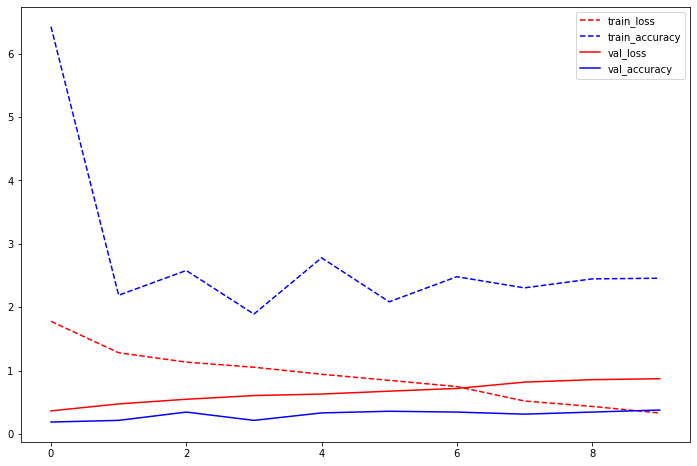

In [75]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,8))
plt.plot(train_loss_list,'--',c='red')
plt.plot(val_loss_list,'--',c='blue')
plt.plot(train_accuracy_list,'-',c='red')
plt.plot(val_accuracy_list,'-',c='blue')
plt.legend(['train_loss','train_accuracy', 'val_loss','val_accuracy'])
plt.show()


In [76]:
# 평가에 사용될 데이터를 확습에 사용된 데이터와 같은 방식으로 전처리
# 먼저 베이스라인
transform_base = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor()])
test_base = ImageFolder(root='./splitted2/test',transform=transform_base)  
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [77]:
# 전이학습에 필요한 전처리
transform_resNet = transforms.Compose([
        transforms.Resize([64,64]),  
        transforms.RandomCrop(52),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    
test_resNet = ImageFolder(root='./splitted2/test', transform=transform_resNet) 
test_loader_resNet = torch.utils.data.DataLoader(test_resNet, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [78]:
#베이스라인 모델 성능 평가하기
baseline=torch.load('baseline.pt')

# baseline.to(torch.device("cpu"))
# 모델을 평가모드로 전환
baseline.eval()  

# evaluate()함수를 이용하여 테스트 데이터에 대한 정확도 측정
test_loss, test_accuracy = evaluate(baseline, test_loader_base)

print('baseline test acc:  ', test_accuracy)

baseline test acc:   32.6797385620915


In [79]:
#Transfer Learning 모델 성능 평가하기
resnet50=torch.load('resnet50.pt') 

# 모델을 평가모드로 전환
resnet50.eval()  

# evaluate()함수를 이용하여 테스트 데이터에 대한 정확도 측정
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet)

print('ResNet test acc:  ', test_accuracy)

ResNet test acc:   14.379084967320262


## 새로운 이미지로 테스트(인터넷에서 다운 받은 이미지)

In [100]:
new_resNet = ImageFolder(root='./newImage', transform=transform_resNet) 
new_loader_resNet = torch.utils.data.DataLoader(new_resNet, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [102]:
new_resNet

Dataset ImageFolder
    Number of datapoints: 2
    Root location: ./newImage
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               RandomCrop(size=(52, 52), padding=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [104]:
#Transfer Learning 모델 성능 평가하기
resnet50=torch.load('resnet50.pt') 

# 모델을 평가모드로 전환
resnet50.eval()  

# evaluate()함수를 이용하여 테스트 데이터에 대한 정확도 측정
new_loss, new_accuracy = evaluate(resnet50, new_loader_resNet)

print('ResNet new acc:  ', new_accuracy)

ResNet new acc:   50.0
